# Computational Intelligence - Homework 3

#### Ali Asghar Kerai - ak06857
#### Muhammad Jazzel Mehmood - mm06886

- country grouping - direct plot geopandas
- state, country grouping -- isko plot nei kr skte
    - lat long wise - nan drop -- converting lat long to state names using geocoding - plot geopandas



### Importing Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import geopandas as gpd
import requests
import time


### Reading & Normalizing Data

In [2]:
data = pd.DataFrame()
def read_normalize_data():
    # Reading data from csv
    data = pd.read_csv('Q1_countrydata.csv')


    # data = data.drop(['Province_State'], axis=1)
    # data = data.drop(['Country_Region'], axis=1)
    data = data.drop(['Last_Update'], axis=1)
    # data = data.drop(['Lat'], axis=1)
    # data = data.drop(['Long_'], axis=1)

    # combine state and region
    data['State'] = None
    data['Color'] = None

    for idx, row in data.iterrows():
        if pd.isnull(row['Province_State']):
            data.at[idx, 'State'] = row['Country_Region']
        else:
            data.at[idx, 'State'] = row['Province_State'] + ", " + row['Country_Region']


    data = data.drop(['Province_State'], axis=1)
    data = data.drop(['Country_Region'], axis=1)

    # sum of confirmed, deaths and recovered for each Country_Region
    # data = data.groupby('Country_Region').sum().reset_index()

    # log 
    data['Confirmed'] = np.log1p(data['Confirmed'])
    data['Deaths'] = np.log1p(data['Deaths'])
    data['Recovered'] = np.log1p(data['Recovered'])

    # # Normalize Confirmed, Deaths and Recovered columns with max
    data['Confirmed'] = data['Confirmed'] / data['Confirmed'].max()
    data['Deaths'] = data['Deaths'] / data['Deaths'].max()
    data['Recovered'] = data['Recovered'] / data['Recovered'].max()

    # drop where lat long is nan
    data = data.dropna(subset=['Lat', 'Long_'])

    return data

### SOM 

In [12]:
# Training SOM
class SOM: 
    def __init__(self, learning_decay_rate, radius_decay_rate, iterations, weights, grid, nodes, data):
        self.learning_decay_rate = learning_decay_rate
        self.radius_decay_rate = radius_decay_rate
        self.iterations = iterations
        self.weights = weights
        self.grid = grid
        self.nodes = nodes

        self.data = data

        self.iteration = 0

    def run(self):
        learning_decay = self.learning_decay_rate
        radius_decay = self.radius_decay_rate

        print("SOM Training Started")
        self.plot()
        for i in range(1, self.iterations + 1):
            self.iteration = i
            random_row = self.data.sample()

            index = random_row.index.values[0]
            random_row = random_row.to_numpy()
            lat, long, confirmed, deaths, recovered, state, color = random_row[0].tolist()

            bmu, index_bmu = self.get_bmu({"confirmed": confirmed, "deaths": deaths, "recovered": recovered})

            for index in range(self.nodes):
                twod_index = np.unravel_index(index, (self.grid, self.grid))
                distance_to_bmu = pow((twod_index[0] - index_bmu[0])**2 + (twod_index[1] - index_bmu[1])**2, 1/2)
                if distance_to_bmu < radius_decay:
                    theta = math.exp(-((distance_to_bmu**2)/(2*(radius_decay**2))))
                    self.weights[index] = self.weights[index] + learning_decay * theta * ([confirmed, deaths, recovered, 1] - self.weights[index])

            learning_decay = self.learning_decay_rate * math.exp((-i/self.iterations))
            radius_decay = self.radius_decay_rate * math.exp((-i/self.iterations))

        print("SOM Training Finished")
        self.plot()

    def get_distance(self, sample, weight):
        return pow((weight[0] - sample["confirmed"])**2 + (weight[1] - sample["deaths"])**2 + (weight[2] - sample["recovered"])**2, 1/2)


    def get_diff_array(self, sample):
        return [self.get_distance(sample, weight) for weight in self.weights]
        
    def get_bmu(self, sample):
        diff_array = self.get_diff_array(sample)
        bmu = min(diff_array)
        index_bmu = np.unravel_index(diff_array.index(bmu), (self.grid, self.grid))

        return bmu, index_bmu
    
    def plot(self):
        fig, ax = plt.subplots()
        for i in range(self.grid):
            for j in range(self.grid):
                ax.add_patch(plt.Rectangle((i, j), 1, 1, color=self.weights[i*10+j]))

        plt.axis('scaled')
        plt.title(f'SOM - Iteration: {self.iteration}')
        plt.show()

    def assign_colors_to_states(self):
        self.data['Color'] = None

        for index, row in self.data.iterrows():
            lat, long, confirmed, deaths, recovered, state, color = row

            bmu, index_bmu = self.get_bmu({"confirmed": confirmed, "deaths": deaths, "recovered": recovered})

            color = self.weights[index_bmu[0]*10 + index_bmu[1]]
            # print(f'{country} - BMU: {index_bmu} - Color: {color}')
            self.data.at[index, 'Color'] = list(color)

        return self.data

In [13]:
data = read_normalize_data()
data

,Lat,Long_,Confirmed,Deaths,Recovered,State,Color
0,33.939110,67.709953,0.733790,0.694063,0.730196,Afghanistan,None
1,41.153300,20.168300,0.742940,0.639024,0.716850,Albania,None
2,28.033900,1.659600,0.778742,0.715179,0.763320,Algeria,None
3,42.506300,1.521800,0.609213,0.400839,0.612071,Andorra,None
4,-11.202700,17.873900,0.661174,0.542367,0.639863,Angola,None
...,...,...,...,...,...,...,...
3974,15.552727,48.516388,0.517423,0.578803,0.497056,Yemen,None
3975,-13.133897,27.849332,0.673825,0.538988,0.675993,Zambia,None
3976,-19.015438,29.154857,0.647999,0.535477,0.640922,Zimbabwe,None
3977,60.388600,-162.890520,0.342390,0.000000,0.000000,"Alaska, United States",None


In [14]:
iterations = 4000
learning_decay_rate = 0.2
radius_decay_rate = 5

grid = 10
grid_size = (grid, grid)
sub_grid_size = grid//2
nodes = grid * grid

weights = np.random.rand(nodes, 4) * 0.9 + 0.1

som = SOM(iterations=iterations, learning_decay_rate=learning_decay_rate, radius_decay_rate=radius_decay_rate, weights=weights, grid=grid, nodes=nodes, data=data)

### Running SOM

SOM Training Started


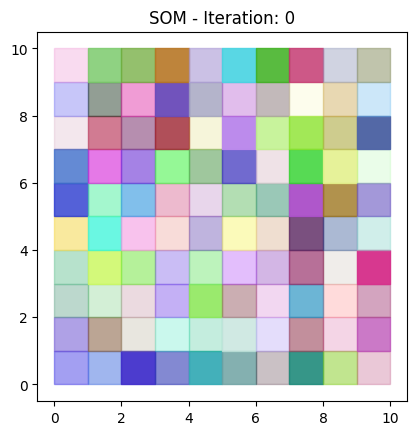

SOM Training Finished


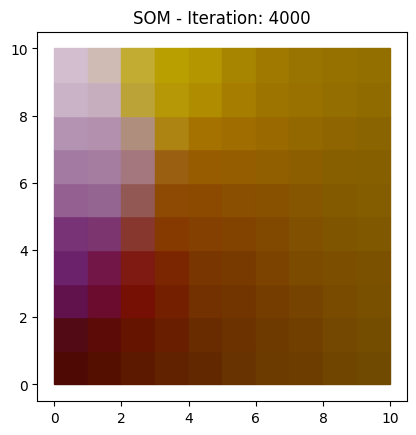

In [15]:
som.run()

### Assigning colors to states

In [16]:
# assigning colors to states
colored_data = som.assign_colors_to_states()

colored_data.head()

,Lat,Long_,Confirmed,Deaths,Recovered,State,Color
0,33.93911,67.709953,0.733790,0.694063,0.730196,Afghanistan,"[0.7809199016244819, 0.6841565545288928, 0.750..."
1,41.15330,20.168300,0.742940,0.639024,0.716850,Albania,"[0.7809199016244819, 0.6841565545288928, 0.750..."
2,28.03390,1.659600,0.778742,0.715179,0.763320,Algeria,"[0.790425621544361, 0.6961277951314072, 0.7808..."
3,42.50630,1.521800,0.609213,0.400839,0.612071,Andorra,"[0.5849888782702225, 0.39721681539331705, 0.57..."
4,-11.20270,17.873900,0.661174,0.542367,0.639863,Angola,"[0.6457294609818873, 0.49205976796594364, 0.63..."


### Plotting map

- Country wise plotting (using geopandas)

In [17]:
colored_country_data = colored_data.copy()

colored_country_data = colored_country_data.groupby('State').sum().reset_index()

for index, row in colored_country_data.iterrows():
    state = row["State"]
    if ", " in state:
        colored_country_data.at[index, 'State'] = state.split(", ")[1]

colored_country_data.head()

,State,Lat,Long_,Confirmed,Deaths,Recovered,Color
0,Italy,42.351222,13.398438,0.709061,0.641931,0.690104,"[0.7071320717476902, 0.5761726038338669, 0.699..."
1,Brazil,-9.023800,-70.812000,0.719870,0.603007,0.715519,"[0.7071320717476902, 0.5761726038338669, 0.699..."
2,Russian Federation,44.693901,40.152042,0.630481,0.409919,0.626034,"[0.5849888782702225, 0.39721681539331705, 0.57..."
3,Afghanistan,33.939110,67.709953,0.733790,0.694063,0.730196,"[0.7809199016244819, 0.6841565545288928, 0.750..."
4,Mexico,21.885300,-102.291600,0.659183,0.651920,0.000000,"[0.7274694046035705, 0.6219641500511409, 0.002..."


C:\Users\Jezzel\AppData\Local\Temp\ipykernel_25252\4241393703.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


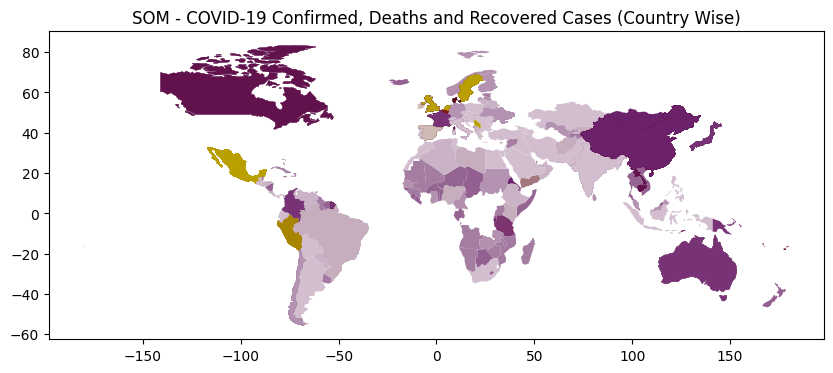

In [18]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

world = world.merge(colored_country_data, left_on='name', right_on='State')

fig, ax = plt.subplots(figsize=(10, 10))
world.plot(ax=ax, color=world['Color'], legend=True)
plt.title('SOM - COVID-19 Confirmed, Deaths and Recovered Cases (State Wise)')
plt.show()

<span style="color:red">Note: The states that match the names in the geopandas library are colored on the map. </span>



- Country wise plotting (using geoencoding - converting lat long to country names)

In [3]:
# Loading colored data from csv (Saved in below cell to save time while running again)
colored_states_data = pd.read_csv('Q1_countrydata_colored.csv')

#### Getting State data using latitudes, longitudes 

<span style="color:red">No need to run it again, just load the csv in above cell and skip the next cell.</span>

- If there's no csv file `Q1_countrydata_colored.csv` in directory then uncomment the last line
    `# init()`
    to generate csv

In [20]:
# getting city, state and country from lat and long using openstreetmap api
colored_states_data = colored_data.copy()

colored_states_data["City"] = None
colored_states_data["Country"] = None

def init():
    def city_state_country(lat, long):

        request = f"https://nominatim.openstreetmap.org/reverse?lat={lat}&lon={long}&format=json&accept-language=en"

        response = requests.get(request)
        _data = response.json()
        try:
            _data = _data['address']
            city, state, country = "", "", ""

            if 'city' in _data:
                city = _data['city']
            if 'state' in _data:
                state = _data['state']
            if 'country' in _data:
                country = _data['country']

            return city, state, country
        except:
            print(lat, long)
            return "", "", ""


    start_time = time.time()

    for idx, row in colored_data.iterrows():
        lat, long, confirmed, deaths, recovered, state, color = row
        city, state, country = city_state_country(lat, long)

        colored_states_data.at[idx, 'City'] = city
        colored_states_data.at[idx, 'State'] = state
        colored_states_data.at[idx, 'Country'] = country


    colored_states_data.to_csv('Q1_countrydata_colored.csv', index=False)
    colored_states_data.head()

    print(f"Time taken: {time.time() - start_time}")

# init()
colored_states_data


11.225999 92.968178
13.6999972 72.1833326
25.768923 126.668016
Time taken: 4254.86520075798


,Lat,Long_,Confirmed,Deaths,Recovered,State,Color,City,Country
0,33.939110,67.709953,0.733790,0.694063,0.730196,Ghazni Province,"[0.7809199016244819, 0.6841565545288928, 0.750...",,Afghanistan
1,41.153300,20.168300,0.742940,0.639024,0.716850,Central Albania,"[0.7809199016244819, 0.6841565545288928, 0.750...",,Albania
2,28.033900,1.659600,0.778742,0.715179,0.763320,Adrar,"[0.790425621544361, 0.6961277951314072, 0.7808...",,Algeria
3,42.506300,1.521800,0.609213,0.400839,0.612071,,"[0.5849888782702225, 0.39721681539331705, 0.57...",,Andorra
4,-11.202700,17.873900,0.661174,0.542367,0.639863,Malanje Province,"[0.6457294609818873, 0.49205976796594364, 0.63...",,Angola
...,...,...,...,...,...,...,...,...,...
3974,15.552727,48.516388,0.517423,0.578803,0.497056,Hadramaut Governorate,"[0.6424211650606595, 0.4676155093956014, 0.493...",,Yemen
3975,-13.133897,27.849332,0.673825,0.538988,0.675993,Copperbelt Province,"[0.7003740662543807, 0.5678817893788775, 0.684...",,Zambia
3976,-19.015438,29.154857,0.647999,0.535477,0.640922,Midlands Province,"[0.6457294609818873, 0.49205976796594364, 0.63...",,Zimbabwe
3977,60.388600,-162.890520,0.342390,0.000000,0.000000,Alaska,"[0.31128315437809034, 0.03555186870483048, 0.0...",,United States


C:\Users\Jezzel\AppData\Local\Temp\ipykernel_18076\4181222429.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


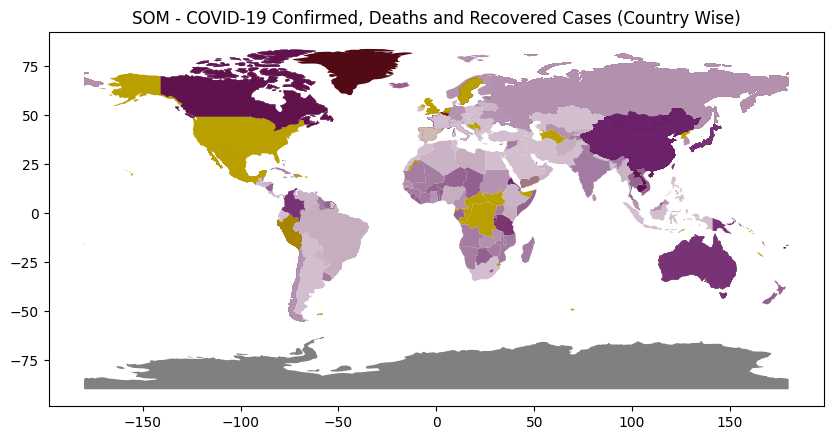

In [33]:
# Creating World Map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

world = world.merge(colored_states_data, left_on='name', right_on='Country', how='left')

import ast

for index, row in world.iterrows():
    if pd.isnull(row['Color']):
        if(row['name'] == 'Antarctica'):
            world.at[index, 'Color'] = "grey"
        else:
            world.at[index, 'Color'] = "#BA9F01"
    else:
        color = [eval(c) for c in (row['Color'])[1:-1].split(",")]
        world.at[index, 'Color'] = list(color)

fig, ax = plt.subplots(figsize=(10, 10))
world.plot(ax=ax, color=world['Color'], legend=False)


plt.title('SOM - COVID-19 Confirmed, Deaths and Recovered Cases (Country Wise)')
plt.show()

<span style="color:red">Note: The countries that match the names in the geopandas library are colored on the map. </span>

